In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("Session runs on GOOGLE COLAB")
    !git clone https://github.com/leuchtum/cse-seminar-windprognose.git
    !pip install wandb
    !pip install pandas --upgrade
    sys.path.append('/content/cse-seminar-windprognose/prognose/')
else:
    print("Session runs on LOCAL MACHINE")

Session runs on LOCAL MACHINE


In [2]:
import MLForecast.sources
import MLForecast.preprocessing as prep
import MLForecast.normalize
import MLForecast.networks
import MLForecast.postprocessing
import MLForecast.visualize
from datetime import datetime
import pandas as pd
import wandb
import pprint

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices and IN_COLAB:
    raise("Switch runtime to GPU runtime")

# Login to W&B
Only required once per computer uptime!

In [4]:
wandb.login()

wandb: Currently logged in as: leuchtum (use `wandb login --relogin` to force relogin)


True

# Set parameters

In [5]:
X_WIDTH = 200
Y_WIDTH = 12
SHIFT = 200
INTERPOLATE = 4
SPLIT = (.05, .3, .65) # TEST, VAL, TRAIN
LABEL_COLUMNS = ["WX_15444", "WY_15444"]
EPOCHS = 10
EARLY_STOP = 2

structure = ["LSTM_x", "DROP_d", "DENSE_y", "OUT"]
network_config = {
    #"LSTM": {
    #    "recurrent_regularizer": "L1_0.0001"
    #},
    "x": 128,
    "y": 64,
    "d": 0.3
}

# Make Dataset
This may take a while

In [6]:
print("LOAD")
dwd = MLForecast.sources.DWDStationsHourly(["15444", "04887", "01886", "02886", "03402"], ["wind", "air_temperature", "pressure", "sun"])
df_dwd = dwd.get_data(drop_before=datetime(2010,1,1))
cal = MLForecast.sources.CalendricalDataHourly(start=datetime(2010,1,1))
df_cal = cal.get_data()

df = pd.concat([df_dwd, df_cal], axis=1)


print("INTERPOLATE AND POL2CART")
df = prep.interpolate_columnwise(df, INTERPOLATE)
df =  prep.pol2cart(df)

print("FIT NORMALIZER")
spezial_borders = {
    "WX": (-1, 1),
    "WY": (-1, 1)
}
exclude = ["CAL"]
norm = MLForecast.normalize.MinMaxNormalizer(spezial_border=spezial_borders, exclude=exclude)
norm.fit(df)

print("MAKE X_DF AND Y_DF")
df_x = norm.normalize(df)
df_y = df[LABEL_COLUMNS]

print("SAMPLE")
x, y =  prep.sample_sequences(df_x, df_y, X_WIDTH, Y_WIDTH, SHIFT)


print("SPLIT")
test, val, train =  prep.split_test_val_train(x, y, SPLIT)

test_np =  prep.df_tuple_to_np(test)
val_np =  prep.df_tuple_to_np(val)
train_np =  prep.df_tuple_to_np(train)

LOAD
CHECK FOR NEW FILES AT https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/
15444:   0%|          | 0/8 [00:00<?, ?it/s]DOWNLOAD FILES
READ IN
03402: 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]
INTERPOLATE AND POL2CART
FIT NORMALIZER
MAKE X_DF AND Y_DF
 12%|█▏        | 620/5185 [00:00<00:00, 6196.08it/s]SAMPLE

100%|██████████| 145/145 [00:00<00:00, 5413.26it/s]

100%|██████████| 313/313 [00:00<00:00, 4589.00it/s]

100%|██████████| 72/72 [00:00<00:00, 6110.31it/s]

100%|██████████| 45/45 [00:00<00:00, 4104.28it/s]

100%|██████████| 166/166 [00:00<00:00, 3961.51it/s]

100%|██████████| 260/260 [00:00<00:00, 5875.74it/s]

100%|██████████| 205/205 [00:00<00:00, 5601.22it/s]

100%|██████████| 475/475 [00:00<00:00, 6543.59it/s]

100%|██████████| 23/23 [00:05<00:00,  4.02it/s]
SPLIT


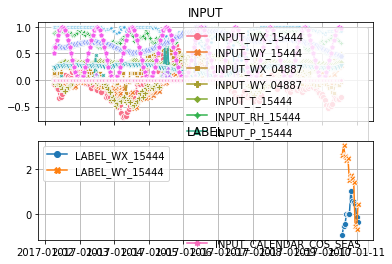

In [5]:
MLForecast.visualize.plot_input_label_example(x[30], y[30])

# Init W&B

In [7]:
database_report =  prep.DataBaseReport(df_x, df_y, x, y, SHIFT, SPLIT).report()

wandb_config = {
    "structure":structure,
    "config":network_config,
    "database": database_report,
    "epochs": EPOCHS,
    "early_stop": EARLY_STOP,
}

wandb.init(
    project='windprognose',
    entity='leuchtum',
    notes="test",
    config=wandb_config,
)

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Build and train model

In [11]:
my_model = MLForecast.networks.LSTMseq2vec(structure, network_config)
my_model.set_input_shape(train[0][0].shape)
my_model.set_output_shape(train[1][0].shape)
my_model.build()
my_model.compile()

my_model.fit(train_np, val_np, early_stop=EARLY_STOP, epochs=EPOCHS, track_wandb=True)

Epoch 1/10
620/620 [==============================] - 111s 177ms/step - loss: 3.1990 - mean_absolute_error: 1.3432 - mean_squared_error: 3.1990 - val_loss: 2.0911 - val_mean_absolute_error: 1.0732 - val_mean_squared_error: 2.0911
Epoch 2/10
620/620 [==============================] - 89s 144ms/step - loss: 2.2209 - mean_absolute_error: 1.1093 - mean_squared_error: 2.2209 - val_loss: 1.9709 - val_mean_absolute_error: 1.0358 - val_mean_squared_error: 1.9709
Epoch 3/10
620/620 [==============================] - 104s 167ms/step - loss: 2.1009 - mean_absolute_error: 1.0715 - mean_squared_error: 2.1009 - val_loss: 1.9452 - val_mean_absolute_error: 1.0271 - val_mean_squared_error: 1.9452
Epoch 4/10
620/620 [==============================] - 106s 171ms/step - loss: 1.9962 - mean_absolute_error: 1.0418 - mean_squared_error: 1.9962 - val_loss: 1.9319 - val_mean_absolute_error: 1.0214 - val_mean_squared_error: 1.9319
Epoch 5/10
620/620 [==============================] - 134s 216ms/step - loss: 1.9

# Analyse performance

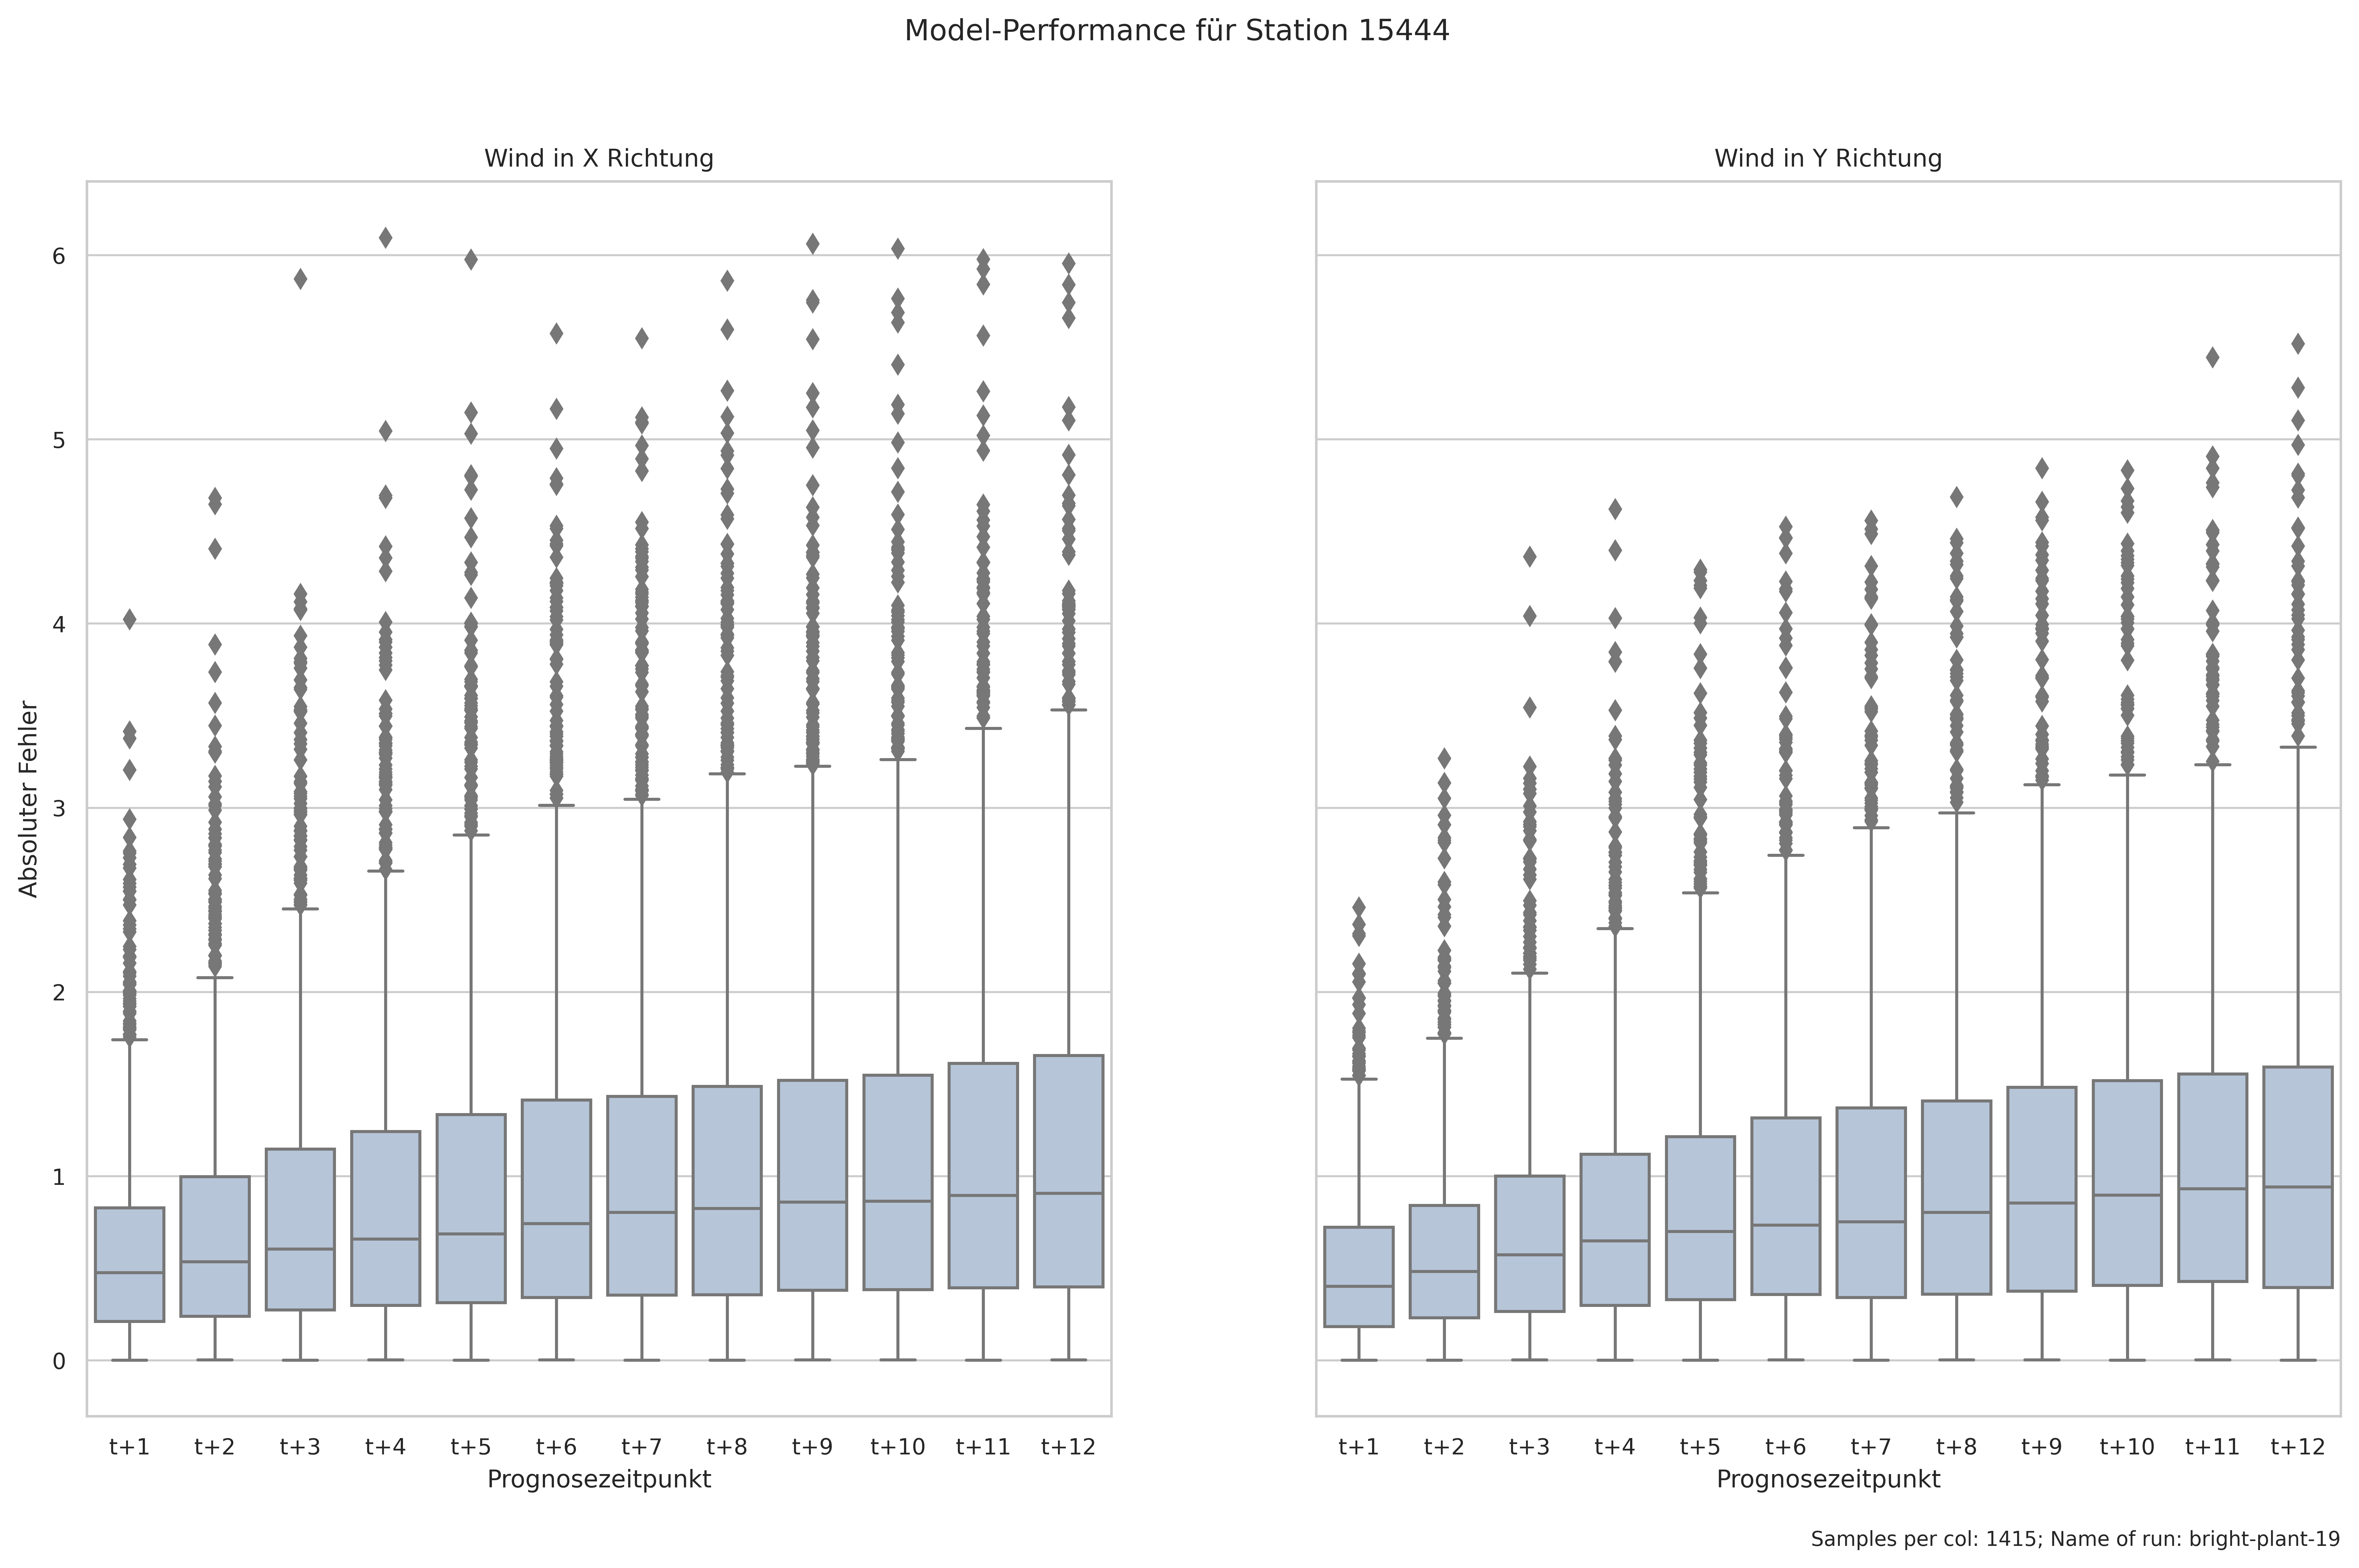

In [12]:
performance = MLForecast.postprocessing.PerformanceAnalyser(my_model.model, test_np)
mae_all = performance.by_metrics("mae")
mae_single = performance.by_metrics("mae", by_individual_column=True)

performance_report = performance.report()

suptitle = "Model-Performance für Station 15444"
subtitles = ["Wind in X Richtung", "Wind in Y Richtung"]
note = f"Samples per col: {len(mae_single[0])}; Name of run: {wandb.run.name}"
xtitle = "Prognosezeitpunkt"
ytitle = "Absoluter Fehler"
MLForecast.visualize.boxplot(mae_single, suptitle, subtitles, xtitle, ytitle, note=note)

In [13]:
pprint.pprint(database_report)

{'end': '2021-05-17 23:00:00',
 'n_measurements': 99720,
 'n_samples': 28317,
 'shift': 200,
 'split': (0.05, 0.3, 0.65),
 'start': '2010-01-01 00:00:00',
 'x_names': ['WX_15444',
             'WY_15444',
             'WX_04887',
             'WY_04887',
             'WX_01886',
             'WY_01886',
             'WX_02886',
             'WY_02886',
             'WX_03402',
             'WY_03402',
             'T_15444',
             'RH_15444',
             'P_15444',
             'SD_15444',
             'T_04887',
             'RH_04887',
             'P_04887',
             'SD_04887',
             'T_01886',
             'RH_01886',
             'T_02886',
             'RH_02886',
             'P_02886',
             'T_03402',
             'RH_03402',
             'SD_03402',
             'CALENDAR_COS_HOUR',
             'CALENDAR_COS_SEAS'],
 'x_shape': (200, 28),
 'x_stats': {'CALENDAR_COS_HOUR': {'count': 99720.0,
                                   'max': 1.0,
           